In [71]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import matplotlib

def conf_intervals(x,n_train,epochs):
    #Returns per-epoch mean rewards/costs as well as lower and upper bounds assuming normally distributed errors
    #given a list of rewards or cost of length n_train*epochs. If the list is shorter, outputs are filled by NaNs. 
    means = []
    lows = []
    highs = []
    for i in range(len(x)//n_train):
        means.append(np.mean(x[i*n_train:(i+1)*n_train]))
        lows.append(means[i]-1.645*np.std(x[i*n_train:(i+1)*n_train])/np.sqrt(n_train))
        highs.append(means[i]+1.645*np.std(x[i*n_train:(i+1)*n_train])/np.sqrt(n_train))
    while len(means)<epochs:
        means.append(np.nan)
        lows.append(np.nan)
        highs.append(np.nan)
    return np.array(means), np.array(lows), np.array(highs)



def plot(files,legend=[],loc_legend="lower left",epochs=10,fig_legend=2,stretch=1,figsize=(10,3),fontsize=10):
    #Plots costs and rewards. Files is a list of the experiment names stored in the corresponding ...+"costs.pkl" 
    #and ...+"rews.pkl" files in the results folder. 
    #Legend lists the names used for the legend in the same order.
    #Epochs is the maximal amount of training epochs for the experiments (all epochs are 25 episodes). 
    #Fig_legend determines whether the legend is displayed in the cost- or reward-subfigure.
    #Stretch can be used to calculate means and confidence intervals using more than one epoch 
    #(useful for longer experiments). 
    #Figsize determines the overall figure size.
    #Fontsize determines the fontsize used for all text in the plots (legend, axis labels and ticks)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    colors = ["orange","blue","red","green","purple"]
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=figsize)
    
    for color,file in zip(colors[:len(files)],files): 
        #load results
        with open("results/"+file+"costs.pkl", "rb") as input_file:
            costs = pickle.load(input_file)
        with open("results/"+file+"rews.pkl", "rb") as input_file:
            rewards = pickle.load(input_file)
        assert file[:3] in ["ppo","sac","td3"]

        #Create lists for train and test episodes. 
        r_train = []
        r_test = []
        c_train = []
        c_test = []
        
        n_train = 25
        if file[:3]=="sac" or file[:3]=="td3":
            n_test = 25
            #only sac and td3 use test episodes
            if len(rewards) == 350:
                n_test = 10
            #some earlier experiments accidentally used 10 instead of 25 episodes. Adjust accordingly.
            elif len(rewards) == 510:
                n_test = 26
            #Similarly, some earlier experiments had an additional environment reset after the test episodes.
            #Don't include this in the training results. 

        else:
            n_train = 25
            n_test = 0
        #write train and test results to the corresponding lists
        for i in range(epochs):
            r_train += rewards[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test]
            c_train += costs[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test]
            if file[:3]=="sac" or file[:3]=="td3":
                r_test += rewards[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)]
                c_test += costs[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)]
                
        #Create confidence intervals
        avr_train,lowerr_train,upperr_train = conf_intervals(r_train,n_train*stretch,epochs/stretch)
        avc_train,lowerc_train,upperc_train = conf_intervals(c_train,n_train*stretch,epochs/stretch)
        
        #Set axis labels 
        ax1.set_xlabel("Environment interactions")
        ax2.set_xlabel("Environment interactions")
        ax1.set_ylabel("Episode reward")
        ax2.set_ylabel("Episode cost")
        
        #Make sure plots use the same scale
        ax1.set_ylim((-5,35))
        
        #Plot rewards
        x = np.arange(epochs/stretch)*1000*n_train*stretch
        ax1.plot(x,avr_train,color=color)
        ax1.fill_between(x,lowerr_train,upperr_train,alpha=1/2,color=color, label='_nolegend_')
        #Include TRPO results 
        if file.split("_")[-1] not in ["cargoal","pointpush","pointgoal2"]:
            ax1.plot(x,np.zeros(len(x))+2.38398003623805,linestyle="dotted",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+6.122558633103186 ,linestyle="dashdot",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+9.407788493971768 ,linestyle="dashed",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+17.146432761106485,color="grey", label='_nolegend_')
            if max(x)>=100000:
                ax1.scatter(100000,2.38398003623805,marker="x",color="grey", label='_nolegend_')
            if max(x)>=500000:
                ax1.scatter(500000,6.122558633103186,marker="x",color="grey", label='_nolegend_')
            if max(x)>=1000000:
                ax1.scatter(1000000,9.407788493971768,marker="x",color="grey", label='_nolegend_')
            if max(x)>=10000000:
                ax1.scatter(10000000,17.146432761106485,marker="x",color="grey", label='_nolegend_')
        
        
        #Make sure plots use the same scale
        ax2.set_ylim((-1,50))
        
        #Plot costs
        ax2.plot(x,avc_train,color=color)
        ax2.fill_between(x,lowerc_train,upperc_train,alpha=1/2,color=color, label='_nolegend_')
        ax2.plot(x,np.zeros(int(epochs/stretch))+25,color="k", label='_nolegend_')
        
        #Include TRPO results
        if file.split("_")[-1] not in ["cargoal","pointpush","pointgoal2"]:
            ax2.plot(x,np.zeros(len(x))+32.517591154162474,linestyle="dotted",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+28.651618995400412 ,linestyle="dashdot",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+21.432270248865336 ,linestyle="dashed",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+25.806451612903246,color="grey", label='_nolegend_')
            if max(x)>=100000:
                ax2.scatter(100000,32.517591154162474,marker="x",color="grey", label='_nolegend_')
            if max(x)>=500000:
                ax2.scatter(500000,28.651618995400412,marker="x",color="grey", label='_nolegend_')
            if max(x)>=1000000:
                ax2.scatter(1000000,21.432270248865336,marker="x",color="grey", label='_nolegend_')
            if max(x)>=10000000:
                ax2.scatter(10000000,25.806451612903246,marker="x",color="grey", label='_nolegend_')
        #Add legend
        if fig_legend==2:
            ax2.legend(legend, loc=loc_legend)
        else:
            ax1.legend(legend, loc=loc_legend)
        
        #print("rews",avr_train)
        #print("costs",avc_train)

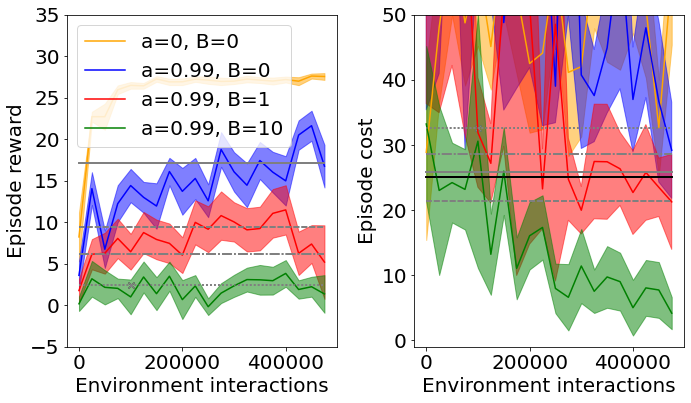

In [72]:
#Figure 1a
plot(["sac_c_ss10k_long","sac_c_ss10k_m001_long","sac_c_ss10k_m001_a1_long","sac_c_ss10k_m001_a10_long"],["a=0, B=0","a=0.99, B=0","a=0.99, B=1","a=0.99, B=10"],epochs=20,fig_legend=1,figsize=(10,6),fontsize=20,loc_legend="upper left")
# We left out a=0.1 as results look very similar to a=0.99 and the plot is a bit crowded ("sac_c_ss10k_m0_long")
plt.tight_layout()
plt.show()

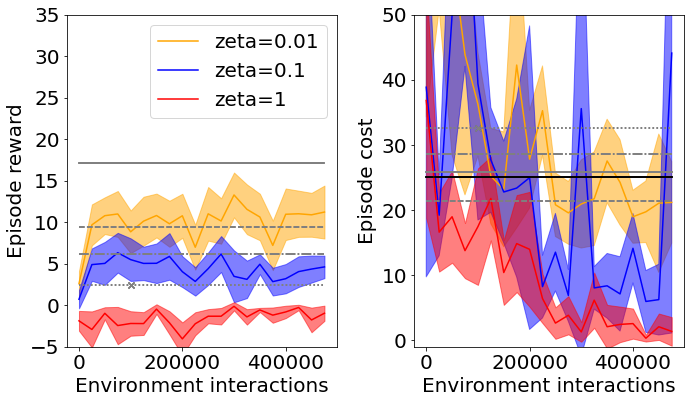

In [73]:
#Figure 1b
plot(["sac_c_ss10k_m001_a1_c001_long2","sac_c_ss10k_m001_a1_c01_long2","sac_c_ss10k_m001_a1_c1_long2"],legend=["zeta=0.01","zeta=0.1","zeta=1"],loc_legend="upper right",fig_legend=1,epochs=20,figsize=(10,6),fontsize=20)
plt.tight_layout()
plt.show()

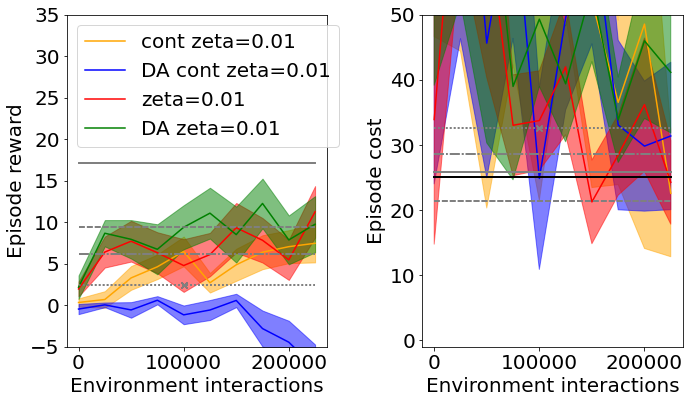

In [74]:
#Figure 2a
plot(["sac_c_ss10k_m001_a1_c001","sac_c_ss10k_m001_a1_c001_data_aug_nobuckets","sac_c_ss10k_m001_a1_c001_buckets","sac_c_ss10k_m001_a1_c001_data_aug"],legend=["cont zeta=0.01","DA cont zeta=0.01","zeta=0.01","DA zeta=0.01"],fig_legend=1,figsize=(10,6),fontsize=20,loc_legend="upper left")
plt.tight_layout()
plt.show()

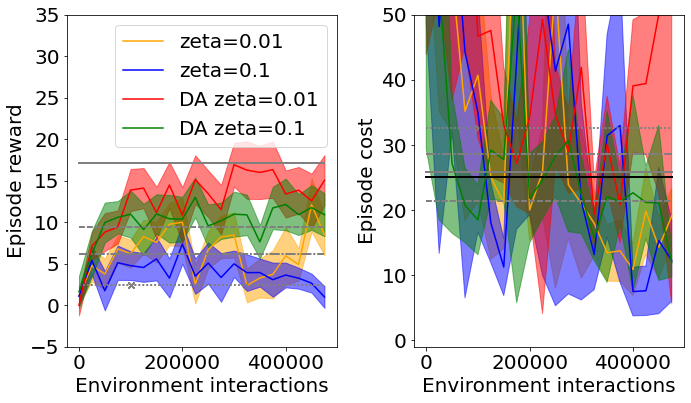

In [75]:
#Figure 2b
plot(["sac_c_ss10k_m001_a1_c001_long","sac_c_ss10k_m001_a1_c01_long","sac_c_ss10k_m001_a1_c001_long_data_aug","sac_c_ss10k_m001_a1_c01_long_data_aug"],legend=["zeta=0.01","zeta=0.1","DA zeta=0.01","DA zeta=0.1"], epochs=20,loc_legend="upper right",fig_legend=1,figsize=(10,6),fontsize=20)#,figsize=(10,6),fontsize=20)
plt.tight_layout()
plt.show()

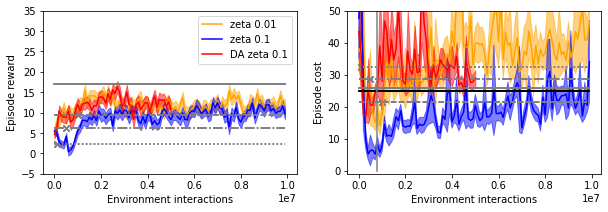

In [76]:
#Figure 3
plot(["sac_c_ss10k_m001_a1_c001_10M","sac_c_ss10k_m001_a1_c01_10M","sac_c_ss10k_m001_a1_c01_data_aug_5M"],epochs=400,legend=["zeta 0.01","zeta 0.1","DA zeta 0.1"],stretch=4,fig_legend=1,loc_legend="upper right")
plt.plot([800000,800000],[0,50],"grey")
plt.show()

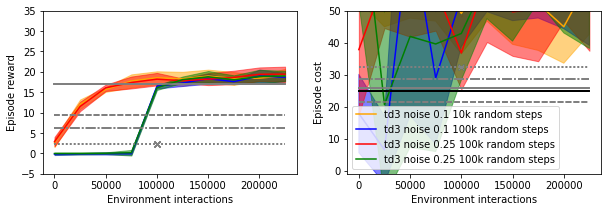

In [77]:
#Figure A1
plot(["td3_an01_ss10k","td3_an01_ss100k","td3_an025_ss10k","td3_an025_ss100k"],legend=["td3 noise 0.1 10k random steps","td3 noise 0.1 100k random steps","td3 noise 0.25 100k random steps","td3 noise 0.25 100k random steps"])

plt.show()

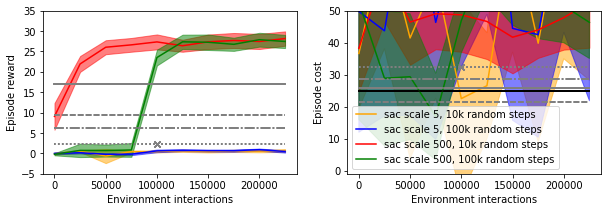

In [78]:
#Figure A2
plot(["sac_a02_ss10k","sac_a02_ss100k","sac_a0002_ss10k","sac_a0002_ss100k"],legend=["sac scale 5, 10k random steps","sac scale 5, 100k random steps","sac scale 500, 10k random steps","sac scale 500, 100k random steps"],loc_legend="lower left")
plt.show()

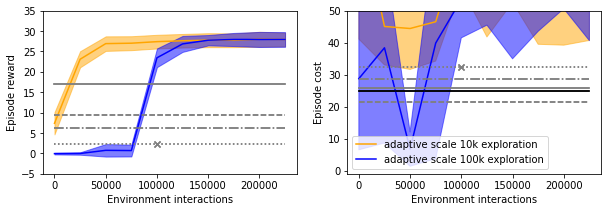

In [79]:
#Figure A3
plot(["sac_c_ss10k","sac_c_ss100k"],legend=["adaptive scale 10k exploration","adaptive scale 100k exploration"])
plt.show()

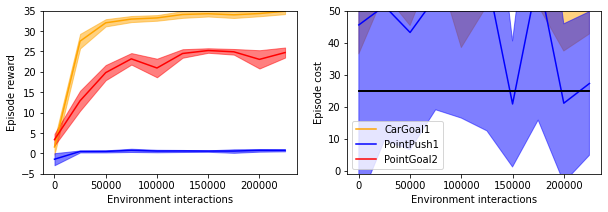

In [80]:
#Figure A4
plot(["sac_c_ss10k_cargoal","sac_c_ss10k_pointpush","sac_c_ss10k_pointgoal2"])

plt.legend(["CarGoal1","PointPush1","PointGoal2"])
plt.show()

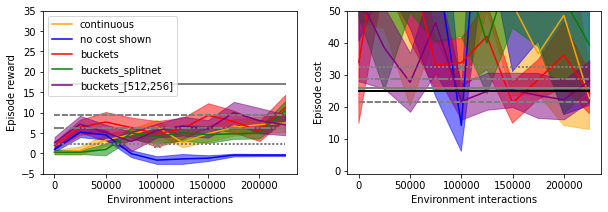

In [81]:
#Figure A5
plot(["sac_c_ss10k_m001_a1_c001","sac_c_ss10k_m001_a1_c001_nocostinfo","sac_c_ss10k_m001_a1_c001_buckets","sac_c_ss10k_m001_a1_c001_buckets_splitnet","sac_c_ss10k_m001_a1_c001_buckets_first_layer_512"],legend=["continuous","no cost shown","buckets","buckets_splitnet","buckets_[512,256]"],fig_legend=1,loc_legend="upper left")

plt.show()

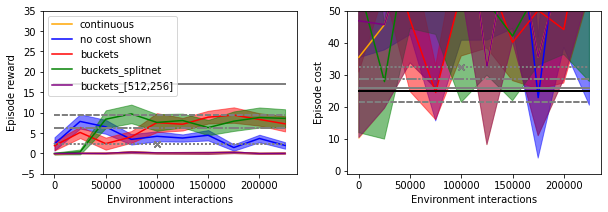

In [82]:
#Figure A6
plot(["td3_ss10k_m001_a1_c001","td3_ss10k_m001_a1_c001_nocostinfo","td3_ss10k_m001_a1_c001_buckets","td3_ss10k_m001_a1_c001_buckets_splitnet","td3_ss10k_m001_a1_c001_buckets_first_layer_512"],legend=["continuous","no cost shown","buckets","buckets_splitnet","buckets_[512,256]"],fig_legend=1,loc_legend="upper left")

plt.show()

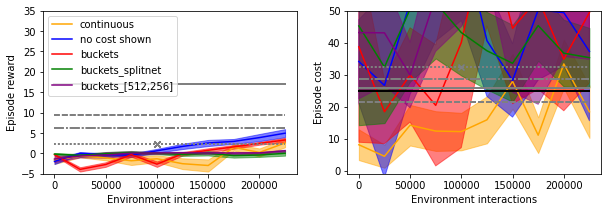

In [83]:
#Figure A7
plot(["ppo_m001_a1_c001","ppo_m001_a1_c001_nocostinfo","ppo_m001_a1_c001_buckets","ppo_m001_a1_c001_buckets_splitnet","ppo_m001_a1_c001_buckets_first_layer_512"],legend=["continuous","no cost shown","buckets","buckets_splitnet","buckets_[512,256]"],fig_legend=1,loc_legend="upper left")

plt.show()

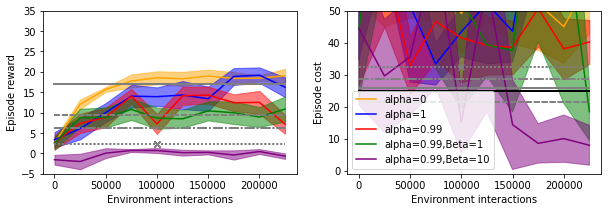

In [84]:
#Figure A8
plot(["td3_an01_ss10k","td3_ss10k_m0","td3_ss10k_m001","td3_ss10k_m001_a1","td3_ss10k_m001_a10"],legend=["alpha=0","alpha=1","alpha=0.99","alpha=0.99,Beta=1","alpha=0.99,Beta=10"])

plt.show()


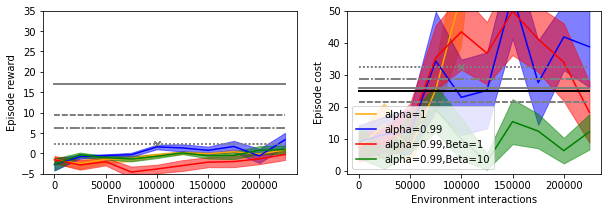

In [85]:
#Figure A9
plot(["ppo_m0","ppo_m001","ppo_m001_a1","ppo_m001_a10"],legend=["alpha=1","alpha=0.99","alpha=0.99,Beta=1","alpha=0.99,Beta=10"])

plt.show()

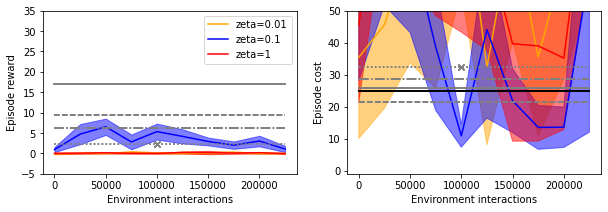

In [86]:
#Figure A10
plot(["td3_ss10k_m001_a1_c001","td3_ss10k_m001_a1_c01","td3_ss10k_m001_a1_c1"],legend=["zeta=0.01","zeta=0.1","zeta=1"],loc_legend="upper right",fig_legend=1)

plt.show()

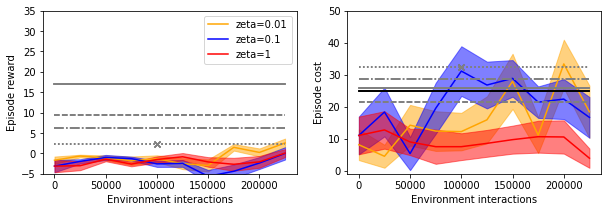

In [87]:
#Figure A11
plot(["ppo_m001_a1_c001","ppo_m001_a1_c01","ppo_m001_a1_c1"],legend=["zeta=0.01","zeta=0.1","zeta=1"],loc_legend="upper right",fig_legend=1)

plt.show()

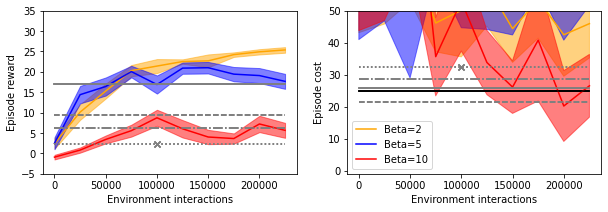

In [88]:
#Figure A12
plot(["sac_c_ss10k_m1_a2","sac_c_ss10k_m1_a5","sac_c_ss10k_m1_a10"],legend=["Beta=2","Beta=5","Beta=10"])
plt.show()

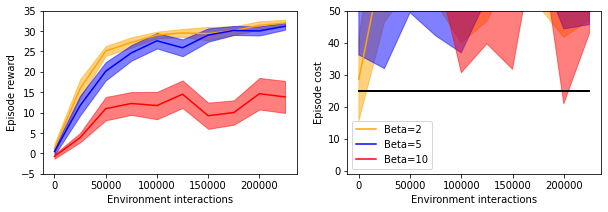

In [89]:
#Figure A13
plot(["sac_c_ss10k_m1_a2_cargoal","sac_c_ss10k_m1_a5_cargoal","sac_c_ss10k_m1_a10_cargoal"],legend=["Beta=2","Beta=5","Beta=10"])
plt.show()

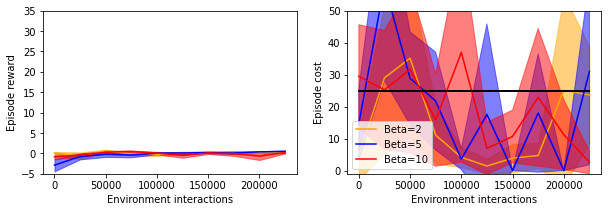

In [90]:
#Figure A14
plot(["sac_c_ss10k_m1_a2_pointpush","sac_c_ss10k_m1_a5_pointpush","sac_c_ss10k_m1_a10_pointpush"],legend=["Beta=2","Beta=5","Beta=10"])
plt.show()

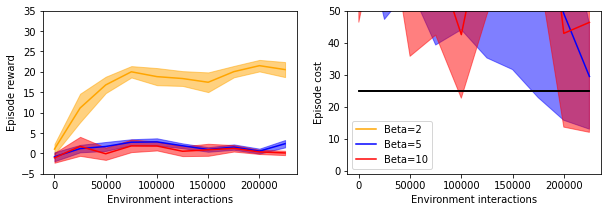

In [91]:
#Figure A15
plot(["sac_c_ss10k_m1_a2_pointgoal2","sac_c_ss10k_m1_a5_pointgoal2","sac_c_ss10k_m1_a10_pointgoal2"],legend=["Beta=2","Beta=5","Beta=10"])
plt.show()

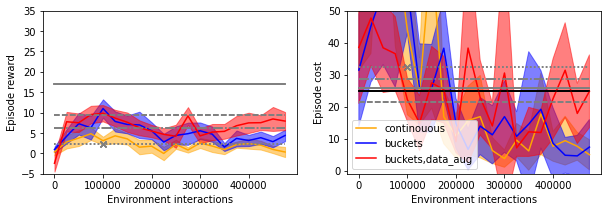

In [92]:
#Figure A16
plot(["sac_c_ss10k_m1_a10_long","sac_c_ss10k_m1_a10_buckets_long","sac_c_ss10k_m1_a10_buckets_data_aug_long"],legend=["continouous","buckets","buckets,data_aug"],epochs=20)
plt.show()

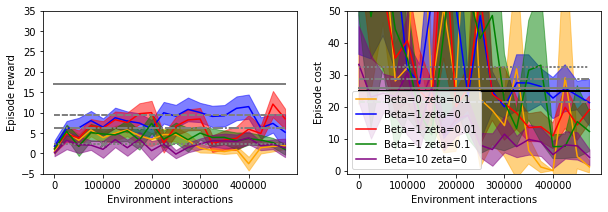

In [93]:
#Figure A17
plot(["sac_c_ss10k_m001_a0_c01_long","sac_c_ss10k_m001_a1_long","sac_c_ss10k_m001_a1_c001_long","sac_c_ss10k_m001_a1_c01_long","sac_c_ss10k_m001_a10_long"],legend=["Beta=0 zeta=0.1","Beta=1 zeta=0","Beta=1 zeta=0.01","Beta=1 zeta=0.1","Beta=10 zeta=0"],epochs=20)
plt.show()

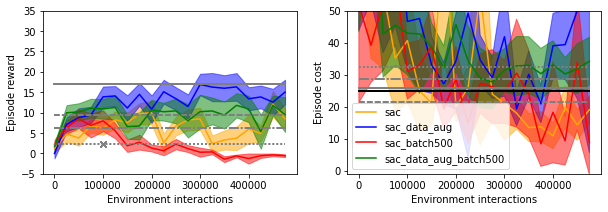

In [94]:
#Figure A18
plot(["sac_c_ss10k_m001_a1_c001_long","sac_c_ss10k_m001_a1_c001_long_data_aug","sac_c_ss10k_m001_a1_c001_long_bigbatch_correct","sac_c_ss10k_m001_a1_c001_long_data_bigbatch"],legend=["sac","sac_data_aug","sac_batch500","sac_data_aug_batch500"],epochs=20)
plt.show()

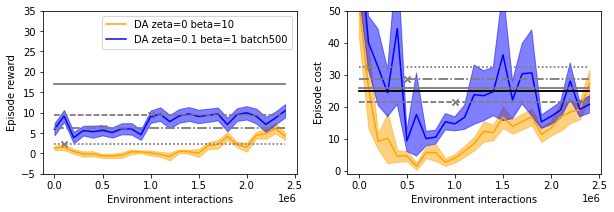

In [95]:
#Figure A19
plot(["sac_c_ss10k_m001_a10_data_aug_2_5M","sac_c_ss10k_m001_a1_c01_data_aug_bigbatch_2_5M"],epochs=100,legend=["DA zeta=0 beta=10","DA zeta=0.1 beta=1 batch500"],stretch=4,fig_legend=1,loc_legend="upper right")
plt.show()

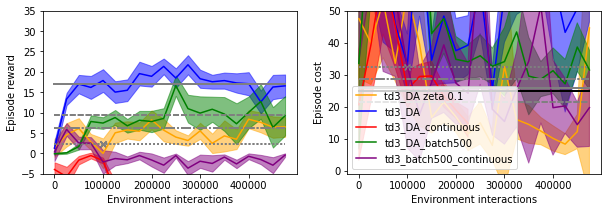

In [96]:
#Figure A20
plot(["td3_ss10k_m001_a1_c01_long_data_aug","td3_ss10k_m001_a1_c001_long_data_aug","td3_ss10k_m001_a1_c001_data_aug_nobuckets","td3_ss10k_m001_a1_c001_long_data_aug_bigbatch","td3_ss10k_m001_a1_c001_long_bigbatch"],legend=["td3_DA zeta 0.1","td3_DA","td3_DA_continuous","td3_DA_batch500","td3_batch500_continuous"],epochs=20)
plt.show()

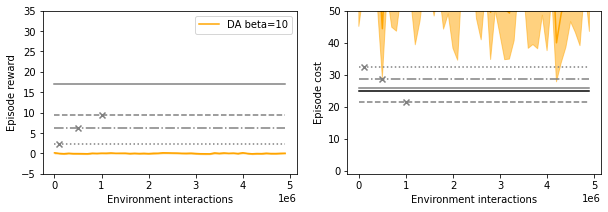

In [97]:
#Figure A21
plot(["td3_ss10k_m001_a1_c01_data_aug_5M"],epochs=200,legend=["DA beta=10","DA zeta 0.1 batch500"],stretch=4,fig_legend=1,loc_legend="upper right")
plt.show()

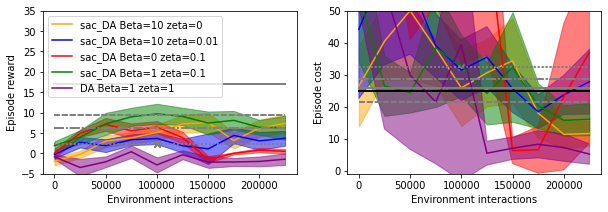

In [98]:
#Figure A22
plot(["sac_c_ss10k_m001_a10_data_aug","sac_c_ss10k_m001_a10_c001_data_aug","sac_c_ss10k_m001_a0_c01_data_aug","sac_c_ss10k_m001_a1_c01_data_aug","sac_c_ss10k_m001_a1_c1_data_aug"],["sac_DA Beta=10 zeta=0","sac_DA Beta=10 zeta=0.01","sac_DA Beta=0 zeta=0.1","sac_DA Beta=1 zeta=0.1","DA Beta=1 zeta=1"],fig_legend=1,loc_legend="upper left")
plt.show()

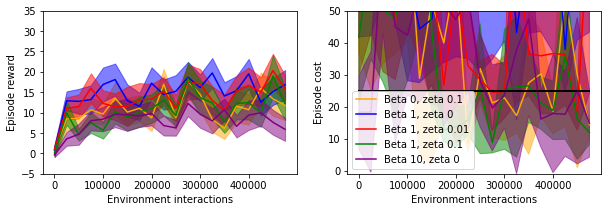

In [99]:
#Figure A23
plot(["sac_c_ss10k_m001_a0_c01_cargoal","sac_c_ss10k_m001_a1_cargoal","sac_c_ss10k_m001_a1_c001_cargoal","sac_c_ss10k_m001_a1_c01_cargoal","sac_c_ss10k_m001_a10_cargoal"],epochs=20,legend=["Beta 0, zeta 0.1","Beta 1, zeta 0", "Beta 1, zeta 0.01","Beta 1, zeta 0.1","Beta 10, zeta 0"])
plt.show()

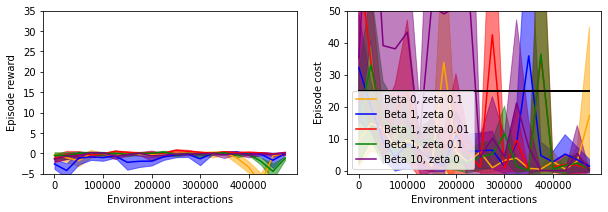

In [100]:
#Figure A24
plot(["sac_c_ss10k_m001_a0_c01_pointpush","sac_c_ss10k_m001_a1_pointpush","sac_c_ss10k_m001_a1_c001_pointpush","sac_c_ss10k_m001_a1_c01_pointpush","sac_c_ss10k_m001_a10_pointpush"],legend=["Beta 0, zeta 0.1","Beta 1, zeta 0", "Beta 1, zeta 0.01","Beta 1, zeta 0.1","Beta 10, zeta 0"],epochs=20)
plt.show()

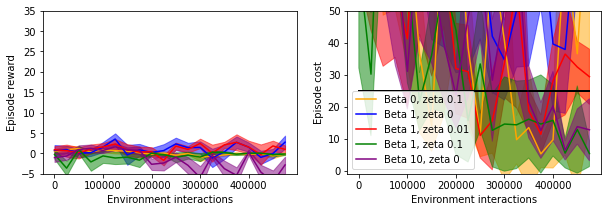

In [101]:
#Figure A25
plot(["sac_c_ss10k_m001_a0_c01_pointgoal2","sac_c_ss10k_m001_a1_pointgoal2","sac_c_ss10k_m001_a1_c001_pointgoal2","sac_c_ss10k_m001_a1_c01_pointgoal2","sac_c_ss10k_m001_a10_pointgoal2"],legend=["Beta 0, zeta 0.1","Beta 1, zeta 0", "Beta 1, zeta 0.01","Beta 1, zeta 0.1","Beta 10, zeta 0"],epochs=20)
plt.show()

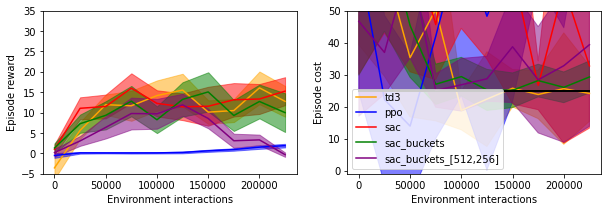

In [102]:
#Figure A26
plot(["td3_ss10k_m001_a1_c001_cargoal","ppo_m001_a1_c001_cargoal","sac_c_ss10k_m001_a1_c001_cargoal","sac_c_ss10k_m001_a1_c001_buckets_cargoal","sac_c_ss10k_m001_a1_c001_buckets_first_layer_512_cargoal"],legend=["td3","ppo","sac","sac_buckets","sac_buckets_[512,256]"])
plt.show()

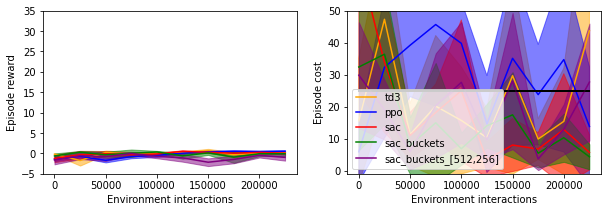

In [103]:
#Figure A27
plot(["td3_ss10k_m001_a1_c001_pointpush","ppo_m001_a1_c001_pointpush","sac_c_ss10k_m001_a1_c001_pointpush","sac_c_ss10k_m001_a1_c001_buckets_pointpush","sac_c_ss10k_m001_a1_c001_buckets_first_layer_512_pointpush"],legend=["td3","ppo","sac","sac_buckets","sac_buckets_[512,256]"])
plt.show()

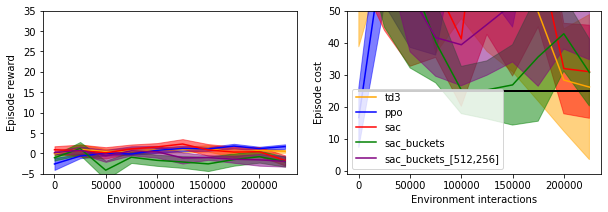

In [104]:
#Figure A28
plot(["td3_ss10k_m001_a1_c001_pointgoal2","ppo_m001_a1_c001_pointgoal2","sac_c_ss10k_m001_a1_c001_pointgoal2","sac_c_ss10k_m001_a1_c001_buckets_pointgoal2","sac_c_ss10k_m001_a1_c001_buckets_first_layer_512_pointgoal2"],legend=["td3","ppo","sac","sac_buckets","sac_buckets_[512,256]"])
plt.show()

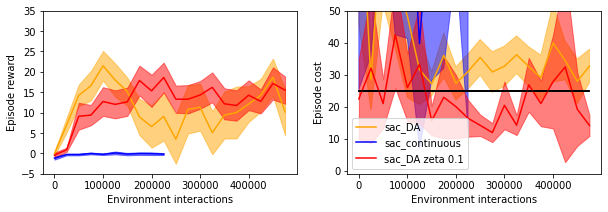

In [105]:
#Figure A29
plot(["sac_c_ss10k_m001_a1_c001_long_data_aug_cargoal","sac_c_ss10k_m001_a1_c001_data_aug_cont_cargoal","sac_c_ss10k_m001_a1_c01_long_data_aug_cargoal"],legend=["sac_DA","sac_continuous","sac_DA zeta 0.1"],epochs=20)

plt.show()

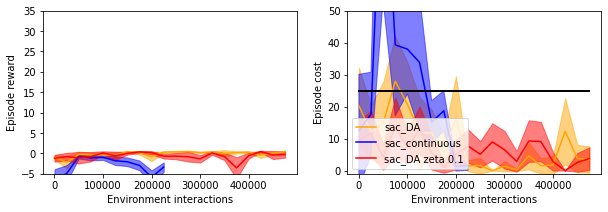

In [106]:
#Figure A30
plot(["sac_c_ss10k_m001_a1_c001_long_data_aug_pointpush","sac_c_ss10k_m001_a1_c001_data_aug_cont_pointpush","sac_c_ss10k_m001_a1_c01_long_data_aug_pointpush"],legend=["sac_DA","sac_continuous","sac_DA zeta 0.1"],epochs=20)
plt.show()

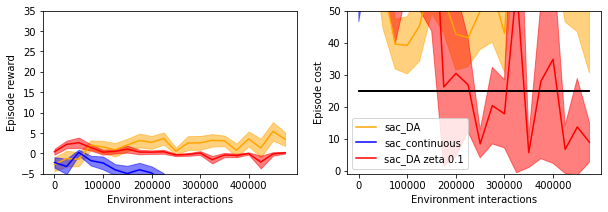

In [107]:
#Figure A31
plot(["sac_c_ss10k_m001_a1_c001_long_data_aug_pointgoal2","sac_c_ss10k_m001_a1_c001_data_aug_cont_pointgoal2","sac_c_ss10k_m001_a1_c01_long_data_aug_pointgoal2"],legend=["sac_DA","sac_continuous","sac_DA zeta 0.1"],epochs=20)
plt.show()

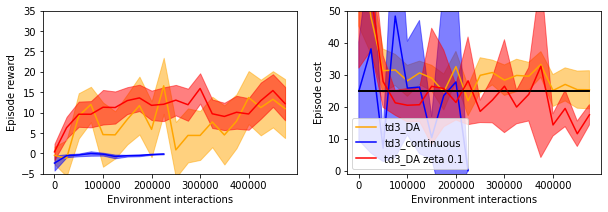

In [108]:
#Figure A32
plot(["td3_ss10k_m001_a1_c001_long_data_aug_cargoal","td3_ss10k_m001_a1_c001_data_aug_cont_cargoal","td3_ss10k_m001_a1_c01_long_data_aug_cargoal"],legend=["td3_DA","td3_continuous","td3_DA zeta 0.1"],epochs=20)
plt.show()

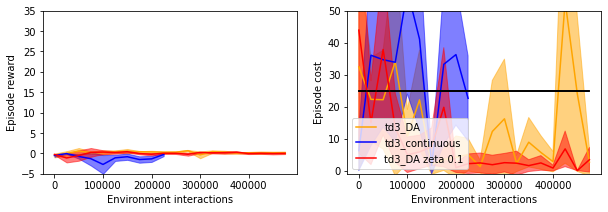

In [109]:
#Figure A33
plot(["td3_ss10k_m001_a1_c001_long_data_aug_pointpush","td3_ss10k_m001_a1_c001_data_aug_cont_pointpush","td3_ss10k_m001_a1_c01_long_data_aug_pointpush"],legend=["td3_DA","td3_continuous","td3_DA zeta 0.1"],epochs=20)
plt.show()

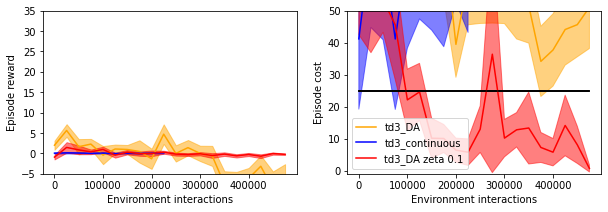

In [110]:
#Figure A34
plot(["td3_ss10k_m001_a1_c001_long_data_aug_pointgoal2","td3_ss10k_m001_a1_c001_data_aug_cont_pointgoal2","td3_ss10k_m001_a1_c01_long_data_aug_pointgoal2"],legend=["td3_DA","td3_continuous","td3_DA zeta 0.1"],epochs=20)
plt.show()

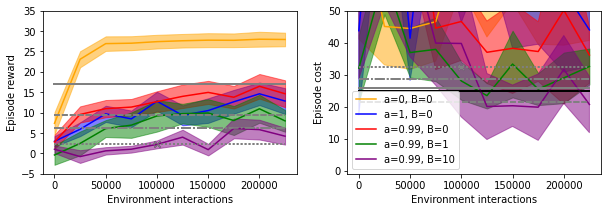

In [111]:
#Figure A35
plot(["sac_c_ss10k","sac_c_ss10k_m0","sac_c_ss10k_m001","sac_c_ss10k_m001_a1","sac_c_ss10k_m001_a10"],["a=0, B=0","a=1, B=0","a=0.99, B=0","a=0.99, B=1","a=0.99, B=10"])

plt.show()


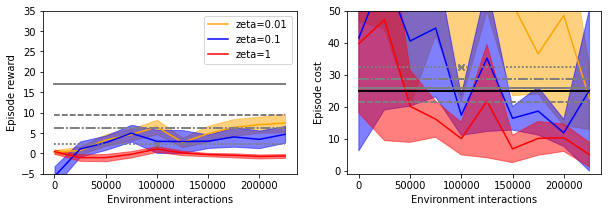

In [112]:
#Figure A.36
plot(["sac_c_ss10k_m001_a1_c001","sac_c_ss10k_m001_a1_c01","sac_c_ss10k_m001_a1_c1"],legend=["zeta=0.01","zeta=0.1","zeta=1"],loc_legend="upper right",fig_legend=1)
plt.show()